In [1]:
import matplotlib.pyplot as plt
from matplotlib.tri import  TriAnalyzer,LinearTriInterpolator, Triangulation
from matplotlib.collections import PolyCollection
import numpy as np
import ipywidgets as widgets
import os 

# Direction labels
DIRS = ["x", "y", "z"]
# Path to the data
PATH = "Cetex_TC1000_0°"
# Cross section area
AREA = 1.89 * 24.1

# Load data files

The DIC results are stored in comma seperated files (*.csv) with this structure: 
```
# Units: length:mm angle:deg time:s strain:% force:N 
# Stage: Stufe 1
stage;index;relative_time;date
"Stufe 1";1;0.0000;"2024-01-29T11:36:15.444"
# Name : Cetex-0°-1_Origin
force;untransformed;transformed
13.0000;13.0000;13.0000
# Name : Flächenkomponente 1
id;x;y;z
0;20.7976;147.0783;-0.1538
1;21.4335;145.6931;-0.1551
...
```

Therefore, we begin by reading the files to store forces and all facet positions in lists. It may happen, that a facet was lost and the number of facets does not agree with the initial image. In that case, we simply drop the frame.

In [2]:
# We store the forces and positions in dictionaries
forces = []
positions = []

# Number of files to read
n_files = len([f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))])

# Iterate over files
for n in range(1, n_files):
    dic_file = f"{PATH}/Flächenkomponente 1_{n:04d}.csv"
    # Read force from file
    with open(dic_file) as f:
        for i, line in enumerate(f):
            if i == 6:
                force = float(line.split(";")[0])
                break
    # Read positions from file
    pos = np.loadtxt(dic_file, skiprows=9, delimiter=";")[:, 1:4]
    if len(positions) > 0:
        if pos.shape[0] != positions[0].shape[0]:
            print(f"Dropping {dic_file} due to lost facets.")
            continue
    # Append to lists
    forces.append(force)
    positions.append(pos)


N = len(forces)

Dropping Cetex_TC1000_0°/Flächenkomponente 1_0176.csv due to lost facets.
Dropping Cetex_TC1000_0°/Flächenkomponente 1_0257.csv due to lost facets.
Dropping Cetex_TC1000_0°/Flächenkomponente 1_0484.csv due to lost facets.
Dropping Cetex_TC1000_0°/Flächenkomponente 1_0487.csv due to lost facets.


# Visualize displacement data as interactive plot

In [3]:
def plot_disp(n):
    pos = positions[n]
    disp = pos - positions[0]
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
    for i in range(3):
        contour = ax[i].tricontourf(pos[:, 0], pos[:, 1], disp[:, i], levels=20)
        ax[i].set_xlabel("x in mm")
        ax[i].set_ylabel("y in mm")
        ax[i].set_title(f"Displacement in {DIRS[i]} in mm")
        ax[i].axis("equal")
        plt.colorbar(contour, ax=ax[i])
    plt.tight_layout()
    plt.show()


widgets.interact(plot_disp,n=widgets.IntSlider(value=N-1, min=0, max=N-1, step=1))

interactive(children=(IntSlider(value=1356, description='n', max=1356), Output()), _dom_classes=('widget-inter…

<function __main__.plot_disp(n)>

# Triangulate the displacement data to compute gradients

In [4]:
# Build a triangulation
pos = positions[0]
tri = Triangulation(pos[:,0], pos[:,1])

# Mask low quality elements at the boundary
mask = TriAnalyzer(tri).get_flat_tri_mask(.01)
tri.set_mask(mask)

# Compute nodes and centers of each triangle
tria_nodes = pos[tri.triangles]
center_x = np.mean(tri.x[tri.triangles], axis=1)
center_y = np.mean(tri.y[tri.triangles], axis=1)


In [5]:
eps_xx = []
eps_yy = []
eps_xy = []

for pos in positions:
    disp = pos - positions[0]

    # Compute displacement gradient
    u_x = LinearTriInterpolator(tri, disp[:,0])
    u_y = LinearTriInterpolator(tri, disp[:,1])
    (u_xx, u_xy) = u_x.gradient(center_x, center_y)
    (u_yx, u_yy) = u_y.gradient(center_x, center_y)

    # Compute strain
    eps_xx.append(u_xx)
    eps_yy.append(u_yy)
    eps_xy.append(0.5 * (u_xy + u_yx))

In [6]:
def plot_strain(n):
    # Plot strains
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
    props ={"ε_xx": eps_xx[n],"ε_xy": eps_xy[n], "ε_yy": eps_yy[n]}
    for i, (lbl, eps) in enumerate(props.items()):
        pc = PolyCollection(tria_nodes[:,:,0:2], array=eps, cmap="magma")
        contour = ax[i].add_collection(pc)
        ax[i].set_title(lbl)
        ax[i].triplot(tri, color="k", lw=0.1)
        ax[i].set_xlabel("x in mm")
        ax[i].set_ylabel("y in mm")
        ax[i].axis("equal")
        plt.colorbar(contour, ax=ax[i])
    plt.tight_layout()
    plt.show()

widgets.interact(plot_strain,n=widgets.IntSlider(value=N-1, min=0, max=N-1, step=1))

interactive(children=(IntSlider(value=1356, description='n', max=1356), Output()), _dom_classes=('widget-inter…

<function __main__.plot_strain(n)>

# Plot stress-strain diagram

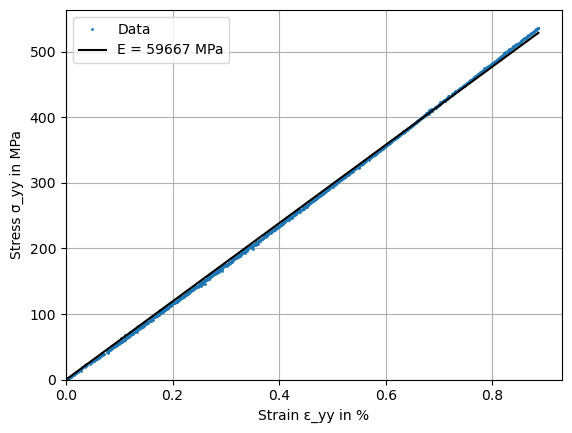

In [7]:
# Average strains
eps_xx_avg = np.array([e.mean() for e in eps_xx])
eps_yy_avg = np.array([e.mean() for e in eps_yy])
eps_xy_avg = np.array([e.mean() for e in eps_xy])
sigma_yy_avg = np.array(forces) / AREA

# Linear regression with zero intercept
A = np.vstack([eps_yy_avg, np.zeros(len(eps_yy_avg))]).T
E, _ = np.linalg.lstsq(A, sigma_yy_avg, rcond=None)[0]
eps_yy_val = np.linspace(0, eps_yy_avg.max(), 100)

# Plot stress-strain curve
plt.plot(100*eps_yy_avg, sigma_yy_avg, "o", markersize=1, label="Data")
plt.plot(100*eps_yy_val, E * eps_yy_val, "-k", label=f"E = {E:.0f} MPa")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Strain ε_yy in %")
plt.ylabel("Stress σ_yy in MPa")
plt.grid("on")
plt.legend()
plt.show()
    

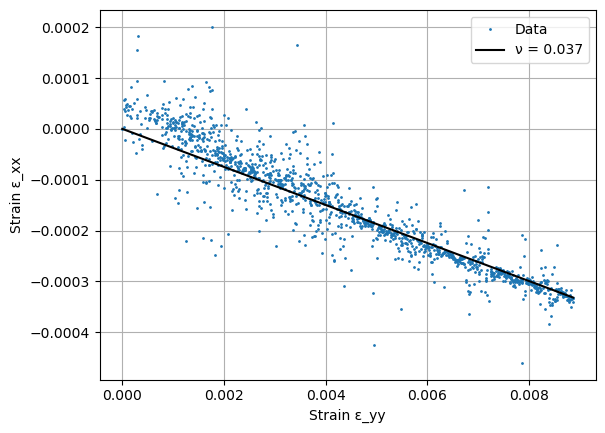

In [8]:
# Linear regression with zero intercept
A = np.vstack([eps_yy_avg, np.zeros(len(eps_yy_avg))]).T
ν, _ = np.linalg.lstsq(A, -eps_xx_avg, rcond=None)[0]
eps_yy_val = np.linspace(0, eps_yy_avg.max(), 100)


plt.plot(eps_yy_avg, eps_xx_avg, "o", markersize=1, label="Data")
plt.plot(eps_yy_val, -ν * eps_yy_val, "-k", label=f"ν = {ν:.3f}")
plt.xlabel("Strain ε_yy")
plt.ylabel("Strain ε_xx")
plt.grid("on")
plt.legend()
plt.show()